In [61]:
import ants
import numpy as np
import os
import pandas as pd
import SimpleITK as sitk
from glob import glob
import shutil
import re
import pydicom
import nibabel as nib
import matplotlib.pyplot as plt
from PIL import Image
from util.results import DataLoader
from util.ploter import Ploter


from corpwechatbot.app import AppMsgSender
app = AppMsgSender(corpid='ww618207d6305f2535',
                   corpsecret='85fYXtyT4AszfLIrmecGMU3KblzOSuIG69wRJwpcfI4',
                   agentid='1000006')
#app.send_text(content='Hello',touser=['ZhaoSheng'])#safe=1
#app.send_image(image_path='')

# Data preprocessing

In [7]:
os.environ[ "ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS" ] = "40"
os.environ[ "ANTS_RANDOM_SEED" ] = "3"
# Test Patients
TEST_LIST = ['003', '099', '033', '136', '011', '086', '077', '102', '016', '022']
ROOT = '/home/iint/lmz/ct_t1/raw_data'            # original dicom folder
SAVE_PATH = r"/home/iint/lmz/ct_t1/reg_data"      # Save the original nii file and overwrite the original nii file based on the iterative registration results of antspy
OUTPUT_PATH = r"/home/iint/lmz/ct_t1/SyNRA_0312"  # Save the result after antspy registration

## utils function

In [8]:
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / (_range)


def purge(_dir, pattern):
    for mode in ["train","test"]:
        for data_mode in ["mr","ct"]:
            for f in os.listdir(os.path.join(_dir,mode,data_mode)):
                if re.search(pattern, f):
                    os.remove(os.path.join(os.path.join(_dir,mode,data_mode), f))

def padding_image(input_data):
    a,b=input_data.shape
    input_data_copy = input_data.copy()
    if a < b:
        edge_width = (b-a)//2
        pic = np.zeros((b,b))
        new_x_length = b-2*edge_width-1
        new_y_length = b
        pic[edge_width+1:b-edge_width,:] = input_data_copy[:new_x_length,:new_y_length]

    elif a > b:
        edge_width = (a-b)//2
        pic = np.zeros((a,a))
        new_x_length = a
        new_y_length = a-2*edge_width-1
        pic[:,edge_width+1:a-edge_width] = input_data_copy[:new_x_length,:new_y_length]
    return pic

## Read the dicom sequence and save it to the `reg_data` folder
> No registration yet, just save to this folder first

In [9]:
def save_nii(files_path,save_path):
    series_IDs = sitk.ImageSeriesReader.GetGDCMSeriesIDs(files_path)
    series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(files_path, series_IDs[0])
    series_reader = sitk.ImageSeriesReader()
    series_reader.SetFileNames(series_file_names)
    image3D = series_reader.Execute()
    # print(f"The size of the image read is：{image3D.GetSize()}")
    sitk.WriteImage(image3D, save_path)

In [10]:
# save_nii("/media/iint/A76A-B6D5/10个浅表病例/patient2","./test.nii")

In [ ]:

df= pd.read_csv(
    filepath_or_buffer = r"/home/iint/lmz/ct_t1/t1_data_info.csv",
    sep= ',',
    error_bad_lines= False ,
    na_values= 'NULL'
)

t1_mri_df = df[df["Modality"] == "MR"]
for index, row in t1_mri_df.iterrows():
    fold_id = str(row["FOLD_ID"]).zfill(3) # 2 变 002
    ct_path = os.path.join(ROOT,fold_id,"CT")
    mr_path = os.path.join(ROOT,fold_id,"MRI",row["SeriesDescription                    "]) # space after
    
    # Uncomment on first use
    # print(ct_path)
    # print(mr_path)
    # save_nii(ct_path,f"{SAVE_PATH}/{fold_id}_ct.nii")
    # save_nii(mr_path,f"{SAVE_PATH}/{fold_id}_t1.nii")

## Preliminary registration
Rigid iterative registration based on SimpleITK.
-> no need now

## Use ants for registration, noise reduction, and N3 correction

In [ ]:
n4_path = os.path.join(OUTPUT_PATH,"n4")
moved_path = os.path.join(OUTPUT_PATH,"moved_ct")
n4_denoise_path = os.path.join(OUTPUT_PATH,"n4_denoise")
plots_path = os.path.join(OUTPUT_PATH,"plots")
os.makedirs(n4_path,exist_ok=True)
os.makedirs(moved_path,exist_ok=True)
os.makedirs(n4_denoise_path,exist_ok=True)
os.makedirs(plots_path,exist_ok=True)


target_files = sorted([_file for _file in sorted(os.listdir(SAVE_PATH)) if "ct" in _file])
input_files =  sorted([_file for _file in sorted(os.listdir(SAVE_PATH)) if "t1" in _file])
assert len(target_files) == len(input_files)


for patient_id,(input_file,target_file) in enumerate(zip(input_files,target_files)):
    moving = ants.image_read(os.path.join(SAVE_PATH,target_file))
    fixed = ants.image_read(os.path.join(SAVE_PATH,input_file))
    filename = input_file.split(".")[-2].split("_")[-2]
    print(f"\n=>\tNow loading:{filename}")
    moving += 1000

    reg = ants.registration(fixed=fixed, moving=moving,
                   type_of_transform='SyNOnly', grad_step=0.5, flow_sigma=0, total_sigma=0, reg_iterations=(100, 40, 20), syn_metric='CC', syn_sampling=4, verbose=True)
    # reg = ants.registration(fixed=fixed, moving=moving,type_of_transform='SyN', reg_iterations = [100,100,20])
    moved = reg["warpedmovout"]
    # take a look at the registration effect and save it as a picture file
    ants.plot(moved,overlay=fixed,overlay_cmap='hot',overlay_alpha=0.5,axis=1,cbar=True,filename=os.path.join(plots_path,filename+"_overlay_1.png"))#
    ants.plot(moved,overlay=fixed,overlay_cmap='hot',overlay_alpha=0.5,axis=0,cbar=True,filename=os.path.join(plots_path,filename+"_overlay_0.png"))#

    # SAVE nii
    ants.image_write(moved,os.path.join(moved_path,filename+".nii"))
    ants.image_write(fixed_n4,os.path.join(n4_path,filename+".nii"))
    ants.image_write(fixed_n4_denoise,os.path.join(n4_denoise_path,filename+".nii"))
    break

## misregistration
> redefine the path

In [ ]:
bad_reg_patients = ["012","017","025","031","040","072","078","090","093","108","111","112"]

ROOT = '/home/iint/lmz/ct_t1/raw_data'
MR_PATH = r"/home/iint/lmz/ct_t1/raw_mr"
CT_PATH = r"/home/iint/lmz/ct_t1/raw_ct"
OUTPUT_PATH = r"/home/iint/lmz/ct_t1/SYNRA_data_3/"

n4_path = os.path.join(OUTPUT_PATH,"n4")
moved_path = os.path.join(OUTPUT_PATH,"moved_ct")
n4_denoise_path = os.path.join(OUTPUT_PATH,"n4_denoise")
plots_path = os.path.join(OUTPUT_PATH,"plots")
os.makedirs(n4_path,exist_ok=True)
os.makedirs(moved_path,exist_ok=True)
os.makedirs(n4_denoise_path,exist_ok=True)
os.makedirs(plots_path,exist_ok=True)

for patient_id,patient in enumerate(bad_reg_patients):
    input_file = os.path.join(MR_PATH,patient+"_t1.nii")
    target_file = os.path.join(CT_PATH,patient+"_ct.nii")
    moving = ants.image_read(target_file)
    fixed = ants.image_read(input_file)
    filename = patient
    print(f"\n=>\tNow loading:{filename}")
    moving += 1000
    moving.plot(title='moving',axis=1)
    fixed.plot(title='fixed',axis=1)
    reg = ants.registration(fixed=fixed, moving=moving,
                       type_of_transform='SyNOnly', grad_step=0.5, flow_sigma=0, total_sigma=0, reg_iterations=(100, 40, 20), syn_metric='CC', syn_sampling=4, verbose=True)
    # reg = ants.registration(fixed=fixed, moving=moving,type_of_transform='SyNOnly', reg_iterations = [100,100,20])

    moved = reg["warpedmovout"]
    ants.plot(moved,overlay=fixed,overlay_cmap='hot',overlay_alpha=0.5,axis=1,cbar=True)#
    # SAVE nii
    ants.image_write(moved,os.path.join(moved_path,filename+".nii"))

## Extract regions of interest using manually drawn masks

In [ ]:
import ants
import numpy as np
import os

t_path = "/home/iint/lmz/ct_t1/SYNRA_data/moved_ct/"
i_path = "/home/iint/lmz/ct_t1/raw_mr/"
m_path = "/home/iint/lmz/ct_t1/seg_results/"
save_path = "/home/iint/lmz/ct_t1/nii_0305/"
target_files = sorted([_file for _file in sorted(os.listdir(t_path)) if "nii" in _file])

for target in target_files:
    filename = target.split("/")[-1].split(".")[0]
    
    target_path = os.path.join(t_path,filename+".nii")
    input_path = os.path.join(i_path,filename+"_t1.nii")
    
    target_img = ants.image_read(target_path)
    input_img = ants.image_read(input_path)
    mask_path = os.path.join(m_path,f"{filename}_t1_Segmentation.seg.nrrd")
    if os.path.exists(mask_path):
        print(f"Found mask for {filename}.")
        mask_img = ants.image_read(mask_path)
        target_img = ants.mask_image(target_img,mask_img)
        input_img = ants.mask_image(input_img,mask_img)
        try:
            target_img.plot(title=f"{filename} CT", axis=1, cbar=True, filename = "/home/iint/lmz/ct_t1/seg_results_png/"+filename+"_ct.png")
            input_img.plot(title=f"{filename} MRI", axis=1, cbar=True, filename = "/home/iint/lmz/ct_t1/seg_results_png/"+filename+"_mri.png")

            target_img.plot(title=f"{filename} CT", axis=0, cbar=True, filename = "/home/iint/lmz/ct_t1/seg_results_png/"+filename+"_ct2.png")
            input_img.plot(title=f"{filename} MRI", axis=0, cbar=True, filename = "/home/iint/lmz/ct_t1/seg_results_png/"+filename+"_mri2.png")
        except:
            pass
    else:
        print(f"Skip {filename}.")
    ants.image_write(input_img,os.path.join(save_path,"input",f"{filename}.nii"))
    ants.image_write(target_img,os.path.join(save_path,"target",f"{filename}.nii"))
    ants.image_write(mask_img,os.path.join(save_path,"mask",f"{filename}.nii"))

## write as png
> rewritten path

> reg_error_img_list：misregistered patient list, skip it directly, not save it as png

> axis_error_img_list：Save a list of patients with the wrong orientation, adjust the order of the axes

In [ ]:
import ants
import re
from PIL import Image

def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / (_range)

def ct_normalization(data):
    # data[data<-1000] = -1000.
    data[data>1800] = 1800.
    output = (data)/1800.
    print(output.max())
    return output

INPUT_ROOT = r"/home/iint/lmz/ct_t1/raw_mr/"
TARGE_ROOT = r"/home/iint/lmz/ct_t1/SyNRA_CT_0312/"
PNT_ROOT = r"/home/iint/lmz/ct_t1/SyNRA_png_0318_003/"
MASK_ROOT = "/home/iint/lmz/ct_t1/seg_results/"

reg_error_img_list = ["012","025","040","063","065","072","078","090","097","108"]
axis_error_img_list = ["012","047","051","088","097","104","117","130","131","133"]
over_light_list = ["031","056","058","059","060","062","063","064","065","067","077","085","110","111","112","113"]
axis_error_img_list_2 = ["095"]
rm_list = ["098","088"]

def padding_image(input_data):
    a,b=input_data.shape
    input_data_copy = input_data.copy()
    if a < b:
        edge_width = (b-a)//2
        pic = np.zeros((b,b))
        new_x_length = b-2*edge_width-1
        new_y_length = b
        pic[edge_width+1:b-edge_width,:] = input_data_copy[:new_x_length,:new_y_length]

    elif a >= b:
        edge_width = (a-b)//2
        pic = np.zeros((a,a))
        new_x_length = a
        new_y_length = a-2*edge_width-1
        pic[:,edge_width+1:a-edge_width] = input_data_copy[:new_x_length,:new_y_length]
    return pic

test_list = ['003', '099', '033', '136', '011', '086', '077', '102', '016', '022']
target_files = sorted(os.listdir(TARGE_ROOT))

i = 0
for patient_id,file_name in enumerate(target_files):
    
    
    file_name = file_name.split(".")[-2]
    # purge(r"/home/iint/lmz/ct_t1/SyNRA_png_0312/",file_name+"_")
    if (file_name in reg_error_img_list) or (file_name in rm_list):
        print(f"Error  =>  Skip {file_name}")
        continue
    print(f"Loading  =>  {file_name}")
    if file_name in test_list:
        PNG_ROOT = os.path.join(PNT_ROOT,"test")
        
    else:
        PNG_ROOT = os.path.join(PNT_ROOT,"train")
    os.makedirs(os.path.join(PNG_ROOT,"ct"),exist_ok=True)
    os.makedirs(os.path.join(PNG_ROOT,"mr"),exist_ok=True)
    os.makedirs(os.path.join(PNG_ROOT,"mask"),exist_ok=True)
    target_filepath = os.path.join(TARGE_ROOT,f"{file_name}.nii")
    input_filepath = os.path.join(INPUT_ROOT,f"{file_name}_t1.nii")
    mask_path = os.path.join(MASK_ROOT,f"{file_name}_t1_Segmentation.seg.nrrd")
    
    target_img = ants.image_read(target_filepath)
    target_img = target_img-target_img.min()
    
    input_img = ants.image_read(input_filepath)
    input_img = input_img-input_img.min()
    
    input_img = ants.n3_bias_field_correction(input_img)
    if os.path.exists(mask_path):
        mask_img = ants.image_read(mask_path)
        target_img = ants.mask_image(target_img,mask_img)
        input_img = ants.mask_image(input_img,mask_img)
    else:
        print(f"No Mask  =>  Skip {file_name}.")
        continue

    target_data = target_img.numpy()
    input_data = input_img.numpy()
    mask_data = mask_img.numpy()
    assert input_data.shape == target_data.shape
    input_data = normalization(input_data)*255.
    target_data = ct_normalization(target_data)*255.
    
    if file_name in axis_error_img_list:
        _a,slices_num,_b = input_data.shape
        for _slice in range(slices_num):
            input_numpy = padding_image(np.array(input_data[:,_slice,:]))
            target_numpy = padding_image(np.array(target_data[:,_slice,:]))
            mask_numpy = padding_image(np.array(mask_data[:,_slice,:]))
            mask_numpy = (mask_numpy)*255.

            

            if (np.max(target_numpy) == np.min(target_numpy)) or (np.max(input_numpy) == np.min(input_numpy)) :
                continue
            input_pic_path = os.path.join(PNG_ROOT,"mr",file_name)+f"_{_slice}.png"
            target_pic_path = os.path.join(PNG_ROOT,"ct",file_name)+f"_{_slice}.png"
            mask_pic_path = os.path.join(PNG_ROOT,"mask",file_name)+f"_{_slice}.png"
            
            input_img = Image.fromarray(input_numpy).resize((256, 256), Image.ANTIALIAS)
            target_img = Image.fromarray(target_numpy).resize((256, 256), Image.ANTIALIAS)
            mask_img = Image.fromarray(mask_numpy).resize((256, 256), Image.ANTIALIAS)
            if input_img.mode != 'L':
                input_img = input_img.convert('L')
            if target_img.mode != 'L':
                target_img = target_img.convert('L')
            if mask_img.mode != 'L':
                mask_img = mask_img.convert('L')
            input_img.save(input_pic_path)
            target_img.save(target_pic_path)
            mask_img.save(mask_pic_path)
            # np.save(input_pic_path,input_numpy)
            # np.save(target_pic_path,target_numpy)
            i = i+1
    else:
        x_nums,y_nums,z_nums = input_data.shape
        _a,_b,slices_num = input_data.shape
        for _slice in range(slices_num):
            target_numpy = np.array(target_data[:,:,_slice])
            input_numpy = np.array(input_data[:,:,_slice])

            mask_numpy = np.array(mask_data[:,:,_slice])
            mask_numpy = (mask_numpy)*255.
            if (np.max(target_numpy) == np.min(target_numpy)) or (np.max(input_numpy) == np.min(input_numpy)) :
                continue
            input_pic_path = os.path.join(PNG_ROOT,"mr",file_name)+f"_{_slice}.png"
            target_pic_path = os.path.join(PNG_ROOT,"ct",file_name)+f"_{_slice}.png"
            mask_pic_path = os.path.join(PNG_ROOT,"mask",file_name)+f"_{_slice}.png"
            input_img = Image.fromarray(input_numpy).resize((256, 256), Image.ANTIALIAS)
            target_img = Image.fromarray(target_numpy).resize((256, 256), Image.ANTIALIAS)
            mask_img = Image.fromarray(mask_numpy).resize((256, 256), Image.ANTIALIAS)
            if input_img.mode != 'L':
                input_img = input_img.convert('L')
            if target_img.mode != 'L':
                target_img = target_img.convert('L')
            if mask_img.mode != 'L':
                mask_img = mask_img.convert('L')
            input_img.save(input_pic_path)
            target_img.save(target_pic_path)
            mask_img.save(mask_pic_path)
            i = i+1
print(f"Done! Total:{i} pairs")

## mask Split to remove unwanted parts
> The result is not good, it has been deprecated, and the mask drawn manually is used instead.

In [ ]:
from ants_reg import reg,save_png
from utils import otsu_crop,load_nii

In [ ]:
otsu_crop(data=args.png_path, temp_id=args.temp_id,size=args.size, delay=args.delay, is_save=args.is_save)

In [ ]:
import os
import sys
import argparse
import cv2
import numpy as np

from utils import all_files_under, n4itk, histogram_matching, get_mask

paser = argparse.ArgumentParser(description='preprocessing')
data = '/home/iint/lmz/ct_t1/reg_png/'
size = 256

paser.add_argument('--temp_id', dest='temp_id', default=2, type=int, help='template image id for histogram matching, default: 2')
paser.add_argument('--size', dest='size', default=256, type=int, help='image width and height (wdith == height), default: 256')
paser.add_argument('--delay', dest='delay', default=0, type=int, help='interval time when showing image, default: 1')
paser.add_argument('--is_save', dest='is_save', default=False, action='store_true', help='save processed image or not, default: False')
args = paser.parse_args()

def main(data, temp_id, size=256, delay=0, is_save=False):
    save_folder = os.path.join(os.path.dirname(data), 'preprocessing')
    if is_save and not os.path.exists(save_folder):
        os.makedirs(save_folder)

    save_folder2 = os.path.join(os.path.dirname(data), 'post')
    if is_save and not os.path.exists(save_folder2):
        os.makedirs(save_folder2)

    # read all files paths
    filenames = all_files_under(data, extension='png')

    # read template image
    temp_filename = filenames[temp_id]
    ref_img = cv2.imread(temp_filename, cv2.IMREAD_GRAYSCALE)
    ref_img = ref_img[:, -size:].copy()
    _, ref_img = n4itk(ref_img)  # N4 bias correction for the reference image

    for idx, filename in enumerate(filenames):
        print('idx: {}, filename: {}'.format(idx, filename))

        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        ct_img = img[:, :size]
        mr_img = img[:, -size:]

        # N4 bias correction
        ori_img, cor_img = n4itk(mr_img)
        # Dynamic histogram matching between two images
        his_mr = histogram_matching(cor_img, ref_img)
        # Mask estimation based on Otsu auto-thresholding
        mask=get_mask(his_mr, task='m2c')
        # Masked out
        masked_ct = ct_img & mask
        masked_mr = his_mr & mask
        canvas = imshow(ori_img, cor_img, his_mr, masked_mr, mask, ct_img, masked_ct, size=size, delay=delay)
        canvas2 = np.hstack((masked_mr, masked_ct, mask))

        if is_save:
            cv2.imwrite(os.path.join(save_folder, os.path.basename(filename)), canvas)
            cv2.imwrite(os.path.join(save_folder2, os.path.basename(filename)), canvas2)

def imshow(ori_mr, cor_mr, his_mr, masked_mr, mask, ori_ct, masked_ct, size=256, delay=0, himgs=2, wimgs=5, margin=5):
    canvas = 255 * np.ones((himgs * size + (himgs-1) * margin, wimgs * size + (wimgs-1) * margin), dtype=np.uint8)

    first_rows = [ori_mr, cor_mr, his_mr, masked_mr, mask]
    second_rows = [ori_ct, 255*np.ones(ori_ct.shape), 255*np.ones(ori_ct.shape), masked_ct, mask]
    for idx in range(len(first_rows)):
        canvas[:size, idx*(margin+size):idx*(margin+size)+size] = first_rows[idx]
        canvas[-size:, idx*(margin+size):idx*(margin+size)+size] = second_rows[idx]

    cv2.imshow("N4 Bias Field Correction", canvas)
    if cv2.waitKey(delay) & 0XFF == 27:
        sys.exit('[*] Esc clicked!')

    return canvas


if __name__ == '__main__':
    main(data=args.data, temp_id=args.temp_id, size=args.size, delay=args.delay, is_save=args.is_save)

## Calculate the dataset mean and standard deviation

In [ ]:
import numpy as np
import cv2
import random
import os
from PIL import Image

# calculate means and std
train_path = "/home/iint/lmz/ct_t1/SyNRA_png_0312/train/mr/"
test_path = "/home/iint/lmz/ct_t1/SyNRA_png_0312/test/mr"


img_h, img_w = 256, 256
A_imgs = []
B_imgs = []
means, stdevs = [], []

files = [_file for _file in os.listdir(train_path) if "png" in _file]

for file in files:
    file_path = os.path.join(train_path,file)

    A = Image.open(file_path).convert('L')
    # split AB image into A and B
    A_np = np.array(A)/255.
    
    A_np_copy = A_np.copy()
    A_imgs.append(A_np_copy)
    
    
    
files = [_file for _file in os.listdir(test_path) if "png" in _file]
# with open(train_txt_path, 'r') as f:
for file in files:
    file_path = os.path.join(test_path,file)

    A = Image.open(file_path).convert('L')
    # split AB image into A and B
    A_np = np.array(A)/255.
    A_np_copy = A_np.copy()
    A_imgs.append(A_np_copy)
    
A_imgs = np.array(A_imgs)
# imgs = imgs.astype(np.float32)/255.
A_img_ravel = A_imgs.ravel()
input_mean = A_img_ravel.mean()
input_std = A_img_ravel.std()
print(f"STD:{input_std}\nMEAN:{input_mean}")

# image post-processing

In [ ]:
import random
import numpy as np
import shutil
import os
import glob
train_path = r"/home/iint/lmz/ct_t1/SyNRA_png_0312/train"
test_path = r"/home/iint/lmz/ct_t1/SyNRA_png_0312/test"
p_name_list = []
for file in os.listdir(os.path.join(train_path,"ct")):
    p_name = file.split("_")[0]
    # print(p_name)
    if p_name not in p_name_list:
        p_name_list.append(p_name)
# shutil.move()
p_name_list = np.array(sorted(p_name_list))
random.seed(123)
random.shuffle (p_name_list)
print(p_name_list)
# for p_name in p_name_list[:10]:
#     # print(p_name)
#     for file in glob.glob(f"/home/iint/lmz/ct_t1/SyNRA_png_0312/train/mr/{p_name}_*.png"):
#         print(file)
#         shutil.move(file,"/home/iint/lmz/ct_t1/SyNRA_png_0312/test/mr/")
#     for file in glob.glob(f"/home/iint/lmz/ct_t1/SyNRA_png_0312/train/ct/{p_name}_*.png"):
#         shutil.move(file,"/home/iint/lmz/ct_t1/SyNRA_png_0312/test/ct/")


In [ ]:
p_name_list = []
for file in os.listdir(os.path.join(test_path,"ct")):
    p_name = file.split("_")[0]
    # print(p_name)
    if p_name not in p_name_list:
        p_name_list.append(p_name)
p_name_list

# Calculate the MAE of each organ

> (Organ delineation needs to be done in advance and saved in the `./results/seg` folder)

## Get the nii to use for sketching

In [ ]:
# First read the pictures in the data set test/mr, save them as the nii of each patient
# and then use the slicer to outline the target area

def get_slice_num(filename):
    return int(filename.split("/")[-1].split("_")[1])
mode = "real_B"
name = "resnet_0314"
epoch = "test_k2_200"

test_imgs_path = f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/{name}/{epoch}/images"
for pname in ['003', '099', '033', '136', '011', '086', '077', '102', '016', '022']:
    output_path = f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/{name}/output/{mode}_nii"
    os.makedirs(output_path,exist_ok=True)
    test_imgs  = sorted([os.path.join(test_imgs_path,_img) for _img in os.listdir(test_imgs_path) if (_img.startswith(pname) ) and (mode in _img)],key=get_slice_num)
    raw_img = ants.image_read(f"/home/iint/lmz/ct_t1/SyNRA_CT_0312/{pname}.nii")
    np_list = []
    for test_img in test_imgs:
        #print(test_img)
        _np = np.array(Image.open(test_img).convert("L"))/255.
        hu_np = _np*(1700+1000)-1000
        np_list.append(hu_np)
    np_array = np.array(np_list).transpose(1,2,0)
    print(f"pname:{np_array.shape}")
    # print(np_list.shape)
    a = ants.from_numpy(np_array)
    a.set_spacing(raw_img.spacing)
    print(a.max())
    # os.makedirs("/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/real_ct_niis/",exist_ok=True)
    # ants.image_write(a,f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/real_ct_niis/{pname}.nii")
    # a.plot(axis=2,slices=[0,1,2,3,4,5,6,7,8,9])
    a = a+1000
    print(pname)
    print(a.numpy().shape)
    # a.plot(cbar=True)

## extract brain

In [50]:
import antspynet
import ants
import numpy as np
import os
mr_nii_path = "/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/real_mr_niis_0327/"#"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/real_mr_niis/"
ct_nii_path = "/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/real_ct_niis_0327/"#"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/real_ct_niis_0318/"
mask_nii_path = "/home/iint/lmz/ct_t1/seg_results"
seg_save_path = "/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/seg/"
def remove_none(input_array):
    output = []
    for _slice in range(input_array.shape[2]):
        if input_array[:,:,_slice].max != 0:
            output.append(input_array[:,:,_slice])
    return np.array(output)



P_LIST = []
target_files = sorted(os.listdir(r"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/real_ct_niis_0327/"))
for target_file in target_files:
    file_name = target_file.split(".")[0]
    P_LIST.append(file_name)
    
print(P_LIST)
print(len(P_LIST))
# i = 0

for pid in ["0"]:
    img = ants.image_read(os.path.join(mr_nii_path,pid+".nii"))
    print(f"{pid} img:{img.shape}")
    #mask_img = ants.image_read(os.path.join(mask_nii_path,pid+"_t1_Segmentation.seg.nrrd"))
    ct_img = ants.image_read(os.path.join(ct_nii_path,pid+".nii"))
    img = ants.n3_bias_field_correction(img)
    img = ants.denoise_image(img)
    
    probability_brain_mask = antspynet.utilities.brain_extraction(img, modality="t1")
    probability_brain_mask[ct_img < -500] = 0
    probability_brain_mask[probability_brain_mask > 0] = 1
    #probability_brain_mask.plot(cbar=True)
    brain_mask = probability_brain_mask.numpy()
    print(f"{pid} mask_img:{brain_mask.shape}")
    # mask_npy = mask_img.numpy()
    np.save(os.path.join(seg_save_path,f"{pid}_brain.npy"),brain_mask)
        
#     print(f"pname img:{img.numpy().shape}")

['002', '003', '004', '005', '006', '009', '010', '011', '015', '016', '017', '018', '019', '020', '021', '022', '023', '026', '027', '029', '030', '031', '033', '034', '035', '036', '038', '039', '042', '043', '044', '045', '046', '047', '049', '050', '051', '053', '054', '056', '058', '059', '060', '062', '064', '066', '067', '068', '069', '070', '071', '073', '074', '076', '077', '081', '082', '084', '085', '086', '087', '089', '091', '093', '094', '096', '099', '100', '101', '102', '104', '105', '106', '107', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '127', '128', '129', '130', '131', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143']
104
002 img:(256, 256, 22)
002 mask_img:(256, 256, 22)
003 img:(256, 256, 22)
003 mask_img:(256, 256, 22)
004 img:(256, 256, 22)
004 mask_img:(256, 256, 22)
005 img:(256, 256, 23)
005 mask_img:(256, 256, 23)
006 img:(256, 256, 22)
006 mask_img:(256, 256, 22)
009 img:(256

## Get the delineated organ mask

In [ ]:
def getmask(array,label):
#     array_copy = array.copy
    output=np.zeros(array.shape)
    output[array==label] = 1
    return output
organs = ["air","eye_l","eye_r","len_l","len_r","on_l","on_r","brainstem","gtv"] # ,"skull" ,"brain"
for pid in TEST_LIST:
    organs_array = ants.image_read(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/seg_nrrd/{pid}_Segmentation-label.nrrd").numpy()
    skull = ants.image_read(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/seg_nrrd/Segmentation_{pid}_01-skull-label.nrrd").numpy()
    assert organs_array.shape==skull.shape
    print(f"-> Patient{pid} shape:{organs_array.shape}")
    for index,organ in enumerate(organs):
        organ_mask = getmask(organs_array,index)
        np.save(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/seg/{pid}_{organ}.npy",organ_mask)
    skull_mask = getmask(skull,1)
    np.save(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/seg/{pid}_skull.npy",skull_mask)

In [28]:
seg_nrrd_path_2 = "/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/seg_nrrd_20220327/"
P_LIST = []
target_files = sorted(os.listdir(seg_nrrd_path_2))
for target_file in target_files:
    file_name = target_file.split("_")[0]
    P_LIST.append(file_name)
    
print(P_LIST)
print(len(P_LIST))


def getmask(array,label):
#     array_copy = array.copy
    output=np.zeros(array.shape)
    output[array==label] = 1
    return output
organs = ["air","eye_l","eye_r","len_l","len_r","on_l","on_r","brainstem"] # ,"skull" ,"brain" ,"gtv"


for pid in P_LIST:
    organs_array = ants.image_read(os.path.join(seg_nrrd_path_2,f"{pid}_Segmentation-label.nrrd")).numpy()
    real_ct = ants.image_read(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/real_ct_niis_0327/{pid}.nii").numpy()
    skull = np.zeros(real_ct.shape)
    skull[real_ct>900] = 1
    assert organs_array.shape==skull.shape
    print(f"-> Patient{pid} shape:{organs_array.shape}")
    for index,organ in enumerate(organs):
        organ_mask = getmask(organs_array,index)
        np.save(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/seg/{pid}_{organ}.npy",organ_mask)
    skull_mask = getmask(skull,1)
    np.save(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/seg/{pid}_skull.npy",skull_mask)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



['002', '004', '005', '006', '009', '010', '015', '017', '018', '019', '020', '021', '023', '026', '027', '029', '030', '031', '034', '035', '036', '038', '039', '042', '043', '044', '045', '046', '047', '049', '050', '051', '053', '054', '056', '058', '059', '060', '062', '064', '066', '067', '068', '069']
44
-> Patient002 shape:(256, 256, 22)
-> Patient004 shape:(256, 256, 22)
-> Patient005 shape:(256, 256, 23)
-> Patient006 shape:(256, 256, 22)
-> Patient009 shape:(256, 256, 158)
-> Patient010 shape:(256, 256, 22)
-> Patient015 shape:(256, 256, 22)
-> Patient017 shape:(256, 256, 22)
-> Patient018 shape:(256, 256, 22)
-> Patient019 shape:(256, 256, 22)
-> Patient020 shape:(256, 256, 22)
-> Patient021 shape:(256, 256, 22)
-> Patient023 shape:(256, 256, 22)
-> Patient026 shape:(256, 256, 12)
-> Patient027 shape:(256, 256, 18)
-> Patient029 shape:(256, 256, 19)
-> Patient030 shape:(256, 256, 20)
-> Patient031 shape:(256, 256, 86)
-> Patient034 shape:(256, 256, 18)
-> Patient035 shape:(2

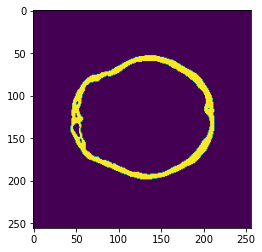

In [25]:
import ants
import numpy as np
# skull = np.load(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/seg/143_skull.npy")

real_ct = ants.image_read(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/real_ct_niis_0327/143.nii")
skull = np.zeros(real_ct.shape)
# real_ct+=1000
# real_ct.plot(cbar=True)
import matplotlib.pyplot as plt
skull[real_ct.numpy()>900]=1
plt.imshow(skull[:,:,10])

## Skin sketching based on OpenCV

In [64]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
ROOT = "/home/iint/lmz/ct_t1/SyNRA_png_0318_003/train/ct" # test
SAVE_PATH = "/home/iint/lmz/ct_t1/SyNRA_png_0318_003/test/skin_npy"
os.makedirs(SAVE_PATH,exist_ok=True)

def get_slice_num(filename):
    return int(filename.split("_")[1].split(".")[0])
# 均值迁移去噪声+二值化 Mean shift denoise + binarization
def threshold_demo(image):
    blurred = cv.pyrMeanShiftFiltering(image, 10, 100)
    gray = cv.cvtColor(blurred, cv.COLOR_BGR2GRAY)
    t, binary = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
    #cv.imshow("mask", binary)
    return binary

for pname in ['070', '071', '073', '074', '076', '081', '082', '084', '085', '087', '089', '091', '093', '094', '096', '100', '101', '104', '105', '106', '107', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '127', '128', '129', '130', '131', '134', '135', '137', '138', '139', '140', '141', '142', '143']:
    _list = sorted([file for file in os.listdir(ROOT) if "png" in file and pname+"_" in file],key = get_slice_num)
    print(_list)
    p_list = []
    for filename in _list:
        print(f"Filename:{filename}")
        pname = filename.split("_")[0]
        filepath = os.path.join(ROOT,filename)

        src1 = cv.imread(filepath)
        src2 = cv.imread(filepath)

        # cv.namedWindow("input", cv.WINDOW_AUTOSIZE)
        # cv.imshow("input", src1)

        binary = threshold_demo(src2)

        # contour discovery
        contours, hierarchy = cv.findContours(binary, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)# cv.CHAIN_APPROX_SIMPLE

        temp_array = np.zeros((256,256))

        for c in range(len(contours)):
            area = cv.contourArea(contours[c])
            if area < 3600:
                continue
            print(area)
            cv.drawContours(src1, contours, c, (0, 0, 255), 2, 8)
            for onedot in contours[c]:
                x = onedot[0,0]
                y = onedot[0,1]
                temp_array[y,x]=1
        # cv.imshow("contours-demo", src1)
        # cv.waitKey(1000)
        # cv.destroyAllWindows()
        # plt.imshow(temp_array)
        # plt.show()
        p_list.append(temp_array)
    p_list = np.array(p_list)
    p_list = p_list.transpose(1,2,0)
    print(f"{pname}:{p_list.shape}")
    np.save(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/seg/{pname}_skin.npy",p_list)

['070_1.png', '070_2.png', '070_3.png', '070_4.png', '070_5.png', '070_6.png', '070_7.png', '070_8.png', '070_9.png', '070_10.png', '070_11.png', '070_12.png', '070_13.png', '070_14.png', '070_15.png', '070_16.png', '070_17.png', '070_18.png']
Filename:070_1.png
26836.0
Filename:070_2.png
27456.5
Filename:070_3.png
27744.0
Filename:070_4.png
28197.0
Filename:070_5.png
28836.5
Filename:070_6.png
28914.0
Filename:070_7.png
28685.5
Filename:070_8.png
28542.5
Filename:070_9.png
28062.0
Filename:070_10.png
27411.5
Filename:070_11.png
26373.5
Filename:070_12.png
25349.5
Filename:070_13.png
24448.5
Filename:070_14.png
22944.0
Filename:070_15.png
21437.0
Filename:070_16.png
19214.5
Filename:070_17.png
16567.5
Filename:070_18.png
13698.5
070:(256, 256, 18)
['071_1.png', '071_2.png', '071_3.png', '071_4.png', '071_5.png', '071_6.png', '071_7.png', '071_8.png', '071_9.png', '071_10.png', '071_11.png', '071_12.png', '071_13.png', '071_14.png', '071_15.png', '071_16.png', '071_17.png', '071_18.png'

## Get the CT nii from the prediction

In [ ]:
import os
import numpy as np
import ants
from PIL import Image
def get_slice_num(filename):
    return int(filename.split("/")[-1].split("_")[1])

test_imgs_path = f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/saru_0318_3/temp_pics/k1_300/"
for mode in ["fake_B"]:
    for pname in ['003', '099', '033', '136', '011', '086', '077', '102', '016', '022']:
        # output_path = f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/saru_0316_005/output/{mode}_nii"
        # os.makedirs(output_path,exist_ok=True)
        test_imgs  = sorted([os.path.join(test_imgs_path,_img) for _img in os.listdir(test_imgs_path) if (_img.startswith(pname) ) and (mode in _img)],key=get_slice_num)
        raw_img = ants.image_read(f"/home/iint/lmz/ct_t1/SyNRA_CT_0312/{pname}.nii")
        np_list = []
        for test_img in test_imgs:
            #print(test_img)
            _np = np.array(Image.open(test_img).convert("L"))/255.
            hu_np = _np*(1700+1000)-1000
            np_list.append(hu_np)
        np_array = np.array(np_list).transpose(1,2,0)
        # print(np_array.shape)
        # print(np_list.shape)
        a = ants.from_numpy(np_array)
        a.set_spacing(raw_img.spacing)
        print(a.max())
        os.makedirs("/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/fake_ct_niis_saru_k1_300/",exist_ok=True)
        ants.image_write(a,f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/fake_ct_niis_saru_k1_300/{pname}.nii")
        # a.plot(axis=2,slices=[0,1,2,3,4,5,6,7,8,9])
        a = a+1000
        a.plot(title=mode,cbar=True)

### save mr for brain extraction

In [53]:
import os
import numpy as np
import ants
def get_slice_num(filename):
    return int(filename.split("/")[-1].split("_")[1].split(".")[0])


test_imgs_path = f"/home/iint/lmz/ct_t1/SyNRA_png_0318_003/test/ct/"


test_p_list= [] 
for pname in [_img.split("_")[0] for _img in os.listdir(test_imgs_path)]:
    if pname not in test_p_list:
        test_p_list.append(pname)
print(f"Train List : \n\t{test_p_list}")
for pname in test_p_list:
    # output_path = f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/saru_0316_005/output/{mode}_nii"
    # os.makedirs(output_path,exist_ok=True)
    test_imgs  = sorted([os.path.join(test_imgs_path,_img) for _img in os.listdir(test_imgs_path) if (_img.startswith(pname) ) ],key=get_slice_num)
    raw_img = ants.image_read(f"/home/iint/lmz/ct_t1/SyNRA_CT_0312/{pname}.nii")
    np_list = []
    for test_img in test_imgs:
        #print(test_img)
        _np = np.array(Image.open(test_img).convert("L"))/255.
        hu_np = _np*(1700+1000)-1000
        np_list.append(hu_np)
    np_array = np.array(np_list).transpose(1,2,0)
    # print(np_array.shape)
    # print(np_list.shape)
    a = ants.from_numpy(np_array)
    a.set_spacing(raw_img.spacing)
    print(a.max())
    os.makedirs("/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/real_ct_niis_0327/",exist_ok=True)
    ants.image_write(a,f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/real_ct_niis_0327/{pname}.nii")
    # a.plot(axis=2,slices=[0,1,2,3,4,5,6,7,8,9])
    a = a+1000
    a.plot(title=pname,cbar=True)

    


Train List : 
	['003', '099', '033', '136', '011', '086', '077', '102', '016', '022']


ValueError: axes don't match array

In [55]:
train_imgs_path = f"/home/iint/lmz/ct_t1/SyNRA_png_0318_003/train/ct/"
train_p_list= [] 
for pname in [_img.split("_")[0] for _img in os.listdir(train_imgs_path)]:
    if pname not in train_p_list:
        train_p_list.append(pname)
print(f"Train List : \n\t{train_p_list}")
for pname in train_p_list:
    # output_path = f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/saru_0316_005/output/{mode}_nii"
    # os.makedirs(output_path,exist_ok=True)
    train_imgs  = sorted([os.path.join(train_imgs_path,_img) for _img in os.listdir(train_imgs_path) if (_img.startswith(pname) ) ],key=get_slice_num)
    raw_img = ants.image_read(f"/home/iint/lmz/ct_t1/SyNRA_CT_0312/{pname}.nii")
    np_list = []
    for test_img in train_imgs:
        _np = np.array(Image.open(test_img).convert("L"))/255.
        hu_np = _np*(1700+1000)-1000
        np_list.append(hu_np)
    np_array = np.array(np_list).transpose(1,2,0)
    # print(np_array.shape)
    # print(np_list.shape)
    a = ants.from_numpy(np_array)
    a.set_spacing(raw_img.spacing)
    print(a.max())
    os.makedirs("/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/real_ct_niis_0327/",exist_ok=True)
    ants.image_write(a,f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/real_ct_niis_0327/{pname}.nii")

Train List : 
	['111', '060', '129', '104', '038', '110', '113', '117', '082', '023', '031', '066', '039', '054', '085', '051', '140', '096', '122', '067', '046', '142', '034', '107', '004', '076', '134', '047', '120', '130', '131', '073', '139', '116', '020', '058', '138', '045', '015', '009', '059', '018', '106', '050', '101', '114', '100', '035', '135', '105', '089', '062', '056', '128', '081', '021', '091', '127', '084', '043', '005', '112', '070', '006', '074', '137', '109', '010', '002', '118', '115', '071', '123', '119', '029', '017', '143', '069', '064', '042', '121', '044', '068', '094', '049', '087', '053', '030', '026', '141', '019', '093', '036', '027']
1700.0


In [46]:
train_p_list= [] 
for pname in [_img.split("_")[0] for _img in os.listdir(train_imgs_path)]:
    if pname not in train_p_list:
        train_p_list.append(pname)
print(f"Train List : \n\t{len(train_p_list)}")
sorted(train_p_list)

Train List : 
	94


['002',
 '004',
 '005',
 '006',
 '009',
 '010',
 '015',
 '017',
 '018',
 '019',
 '020',
 '021',
 '023',
 '026',
 '027',
 '029',
 '030',
 '031',
 '034',
 '035',
 '036',
 '038',
 '039',
 '042',
 '043',
 '044',
 '045',
 '046',
 '047',
 '049',
 '050',
 '051',
 '053',
 '054',
 '056',
 '058',
 '059',
 '060',
 '062',
 '064',
 '066',
 '067',
 '068',
 '069',
 '070',
 '071',
 '073',
 '074',
 '076',
 '081',
 '082',
 '084',
 '085',
 '087',
 '089',
 '091',
 '093',
 '094',
 '096',
 '100',
 '101',
 '104',
 '105',
 '106',
 '107',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '127',
 '128',
 '129',
 '130',
 '131',
 '134',
 '135',
 '137',
 '138',
 '139',
 '140',
 '141',
 '142',
 '143']

## Get the mask, which is the entire head, for subsequent evaluation

In [65]:
import os
import numpy as np
import ants
def get_slice_num(filename):
    return int(filename.split("/")[-1].split("_")[1].split(".")[0])


test_imgs_path = f"/home/iint/lmz/ct_t1/SyNRA_png_0318_003/train/mask"

for pname in ['070', '071', '073', '074', '076', '081', '082', '084', '085', '087', '089', '091', '093', '094', '096', '100', '101', '104', '105', '106', '107', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '127', '128', '129', '130', '131', '134', '135', '137', '138', '139', '140', '141', '142', '143']:
    # output_path = f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/saru_0316_005/output/{mode}_nii"
    # os.makedirs(output_path,exist_ok=True)
    test_imgs  = sorted([os.path.join(test_imgs_path,_img) for _img in os.listdir(test_imgs_path) if (_img.startswith(pname) ) ],key=get_slice_num)
    raw_img = ants.image_read(f"/home/iint/lmz/ct_t1/SyNRA_CT_0312/{pname}.nii")
    np_list = []
    for test_img in test_imgs:
        #print(test_img)
        _np = np.array(Image.open(test_img).convert("L"))/255.
        hu_np = _np#*(1700+1000)-1000
        np_list.append(hu_np)
    np_array = np.array(np_list).transpose(1,2,0)
    # print(np_array.shape)
    # print(np_list.shape)
    a = ants.from_numpy(np_array)
    a.set_spacing(raw_img.spacing)
    print(a.max())
    head_numpy = a.numpy()
    np.save(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/seg/array_{pname}_head.npy",head_numpy)
    # os.makedirs("/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/real_mr_niis_0318/",exist_ok=True)
    # ants.image_write(a,f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/real_mr_niis_0318/{pname}.nii")
    # a.plot(axis=2,slices=[0,1,2,3,4,5,6,7,8,9])
    # a = a+1000
    # a.plot(title=mode,cbar=True)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


## Get mask from RTStruct by rt_utils

In [1]:
from rt_utils import RTStructBuilder
import matplotlib.pyplot as plt

# Load existing RT Struct. Requires the series path and existing RT Struct path
rtstruct = RTStructBuilder.create_from(
  dicom_series_path="/home/iint/hanyang/10个浅表病例/patient1/", 
  rt_struct_path="/home/iint/hanyang/10个浅表病例/patient1/RS.1.2.246.352.71.4.844417004102.315768.20210426110443.dcm", 
)

# View all of the ROI names from within the image
print(rtstruct.get_roi_names())


['Trachea', 'SpinalCord', 'Pituitary', 'Parotid_R', 'PGTV1', 'GTV1', 'CTV1', 'Parotid_L', 'OpticNrv_R', 'OpticNrv_L', 'Lobe_Temporal_R', 'Lobe_Temporal_L', 'Lens_R', 'Lens_L', 'Joint_TM_R', 'Joint_TM_L', 'Glnd_Thyroid', 'Glnd_Submand_R', 'Glnd_Submand_L', 'Eye_R', 'Eye_L', 'Esophagus', 'Cerebrum', 'Cerebellum', 'Cavity_Oral', 'BrainStem', 'Brain', 'Bone_Mandible', 'Body', 'TTCTV1', 'CouchSurface', 'CouchInterior', 'LeftOuterRail', 'RightOuterRail', 'LeftInnerRail', 'RightInnerRail', 'TCTV1']


In [3]:
import os
import numpy as np
os.makedirs(f"/home/iint/hanyang/seg/",exist_ok=True,)
for organ in rtstruct.get_roi_names():
# Loading the 3D Mask from within the RT Struct
    mask_3d = rtstruct.get_roi_mask_by_name(organ).transpose(1,0,2)[150:370,100:320,50:150]
    #[150:370,100:320,50:150]
    # Display one slice of the region
    # first_mask_slice = mask_3d[:, :, 100]
    # plt.imshow(first_mask_slice)
    # plt.colorbar()
    # plt.title(organ)
    # plt.show()
    print(mask_3d.shape)
    np.save(f"/home/iint/hanyang/seg/001_{organ}.npy",mask_3d)

(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)
(220, 220, 100)


### 计算质心

In [2]:
from scipy import ndimage
import numpy
masses = numpy.array([[0,  0,  0,  0],
[0,  1,  0,  0],
[0,  2,  0,  0],
[1,  0,  0,  0],
[1,  1,  0,  1],
[1,  2,  0,  1],
[2,  0,  0,  0],
[2,  1,  0,  0],
[2,  2,  0,  0]])

ndimage.measurements.center_of_mass(masses)

(5.25, 0.75)

## Obtain the organ mask after the outline in the slicer is completed

In [ ]:
def getmask(array,label):
#     array_copy = array.copy
    output=np.zeros(array.shape)
    output[array_==label] = 1
    return output

# real_ct = np.asanyarray(nib.load("./SARUp_dream_3/dose/f").dataobj)
# np.save("./real/real_ct.npy",real_ct)
# fake_ct = np.asanyarray(nib.load("./001_fake.nii").dataobj)
# np.save("./fake/fake_ct.npy",fake_ct)

for pid in ['003', '099', '033', '136', '011', '086', '077', '102', '016', '022']:
    array_ = np.asanyarray(nib.load(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/{pid}_seg.nii").dataobj)
    # 0 air
    array_air = getmask(array_,0)
    np.save(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/seg/array_{pid}_air.npy",array_air)
    # 1 l-lens
    array_lens_l = getmask(array_,1)
    np.save(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/seg/array_{pid}_lens_l.npy",array_lens_l)
    # 2 r-lens
    array_lens_r = getmask(array_,2)
    np.save(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/seg/array_{pid}_lens_r.npy",array_lens_r)
    # 3 shishenjing-l
    array_ssj_l =getmask(array_,3)
    np.save(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/seg/array_{pid}_ssj_l.npy",array_ssj_l)
    # 4 shishenjing-r
    array_ssj_r= getmask(array_,4)
    np.save(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/seg/array_{pid}_ssj_r.npy",array_ssj_r)
    # 5 brain
    array_brain = getmask(array_,5)
    np.save(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/seg/array_{pid}_brain.npy",array_brain)
    # 6 brainstem
    array_brainstem =getmask(array_,6)
    np.save(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/seg/array_{pid}_brainstem.npy",array_brainstem)
    # 6 gtv
    array_gtv =getmask(array_,7)
    np.save(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/seg/array_{pid}_gtv.npy",array_gtv)
    # 7 skull
    array_skull =getmask(array_,8)
    np.save(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/seg/array_{pid}_skull.npy",array_skull)
    print("Done")

## Calculate MAE and save the resulting plot

In [ ]:


# backbones = ["resnet","unet_128","saru"]
backbones = ["test0312_001"]

labels  = {
             "unet_128":"UNet",
             "resnet":"ResNet",
             "saru":"SARU",
             "test0312_001":"test"
           }
organ_labels  = {
                 "lens_l":"Lens(L)",
                 "lens_r":"Lens(L)",
                 "ssj_l":"ON(L)",
                 "ssj_r":"ON(R)",
                 "brain":"Brain",
                 "brainstem":"BrainStem",
                 "gtv":"GTV",
                 "skull":"Skull",
                 "soft_tissue":"Soft tissue",
                 "bone":"Bone",
                 "air":"Air",
                 "skin":"Skin"
                }

patients_list = ["135"]

for net_name in backbones:
    net_nick_name = labels[net_name]
    dl = DataLoader(net_name=net_name,rpath="/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/",epoch="300")
    mae = []
    me = []
    rmse = []
    organs_mae_all = {}
    organs_mae_mean = {}
    organs_mae_std = {}
    
    organs_me_all = {}
    organs_me_mean = {}
    organs_me_std = {}
    
    organs_rmse_all = {}
    organs_rmse_mean = {}
    organs_rmse_std = {}
    
    for pid,pn in enumerate(patients_list,1):
        print(pn)
        dl.load_nii(pn)
        #dl.save_nii(pn,txt_path="/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/mcnp_input_txt/")
        mae.append(dl.mae)
        me.append(dl.me)
        rmse.append(dl.rmse)
        
        #print(dl.organs_mae)
        for organ_name in dl.organs_list:
            all_data.append("mae",dl.organs_mae[organ_name],net_name,organ_name)
            
            if organ_name in organs_mae_all:
                organs_mae_all[organ_name].append(dl.organs_mae[organ_name])
                organs_me_all[organ_name].append(dl.organs_me[organ_name])
                organs_rmse_all[organ_name].append(dl.organs_rmse[organ_name])
            else:
                organs_mae_all[organ_name]=[dl.organs_mae[organ_name]]
                organs_me_all[organ_name]=[dl.organs_me[organ_name]]
                organs_rmse_all[organ_name]=[dl.organs_rmse[organ_name]]
        
        MAE_RESULTS.append([net_nick_name,pid,dl.mae,dl.me,dl.rmse])
    MEAN_MAE_RESULTS[net_nick_name] = str(np.mean(mae)) +","+ str(np.std(mae)) +","+ str(np.mean(me)) +","+ str(np.std(me)) +","+ str(np.mean(rmse))+","+ str(np.std(rmse))
    
    for organ_name in dl.organs_list:
        if organ_name in organs_mae_mean:
            organs_mae_mean[organ_name].append(np.mean(organs_mae_all[organ_name]))
            organs_me_mean[organ_name].append(np.mean(organs_me_all[organ_name]))
            organs_rmse_mean[organ_name].append(np.mean(organs_rmse_all[organ_name]))
        else:
            organs_mae_mean[organ_name] = np.mean(organs_mae_all[organ_name])
            organs_me_mean[organ_name] = np.mean(organs_me_all[organ_name])
            organs_rmse_mean[organ_name] = np.mean(organs_rmse_all[organ_name])
    for organ_name in dl.organs_list:
        if organ_name in organs_mae_std:
            organs_mae_std[organ_name].append(np.std(organs_mae_all[organ_name]))
            organs_me_std[organ_name].append(np.std(organs_me_all[organ_name]))
            organs_rmse_std[organ_name].append(np.std(organs_rmse_all[organ_name]))
        else:
            organs_mae_std[organ_name] = np.std(organs_mae_all[organ_name])
            organs_me_std[organ_name] = np.std(organs_me_all[organ_name])
            organs_rmse_std[organ_name] = np.std(organs_rmse_all[organ_name])
            
    print(f"{net_name}:")
    print(organs_mae_mean)
    print(organs_mae_std)
    ORGAN_RESULTS_MAE[net_name]={}
    ORGAN_RESULTS_MAE[net_name]["mean"]=organs_mae_mean
    ORGAN_RESULTS_MAE[net_name]["std"]=organs_mae_std
    
    ORGAN_RESULTS_ME[net_name]={}
    ORGAN_RESULTS_ME[net_name]["mean"]=organs_me_mean
    ORGAN_RESULTS_ME[net_name]["std"]=organs_me_std
    
    ORGAN_RESULTS_RMSE[net_name]={}
    ORGAN_RESULTS_RMSE[net_name]["mean"]=organs_rmse_mean
    ORGAN_RESULTS_RMSE[net_name]["std"]=organs_rmse_std


## visualization

In [ ]:
plt.style.use('ggplot')
plt.figure(dpi=200)
#plt.title("Result analysis")
data=pd.DataFrame(all_data,columns=['Type', 'MAE(HU)','Backbone',"Organ","Patient"])
data2=data[data["Type"]=="mae"]
data2= data2[~ data2['Organ'].isin(["lens_l","lens_r","ssj_l","ssj_r"])]
# data2= data2[~ data2['Patient'].isin(["geng03_009","geng06_008"])]
sns.boxplot(y='MAE(HU)',x= 'Organ',hue="Backbone",data=data2,showfliers = False,order=["brain","brainstem","gtv","skull","skin","air","all"]) #左图
plt.savefig("/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/pics/organ_mae_boxplot.png")
plt.show()

# Dose calculation

运行完成`test.py --name xxx`之后会在results中保存图片文件，需要:读取图片内容 -> 拼接成3维数组 -> 转换为材料标签值 -> 写入txt -> mcnp计算剂量。

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
from os import listdir
from os.path import splitext
import nibabel as nb
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from nibabel.viewers import OrthoSlicer3D
import scipy.io as io

def nii_to_array(nii_file_path):
    img = nib.load(nii_file_path)
    ct_array = np.asanyarray(img.dataobj)
    ct_array = np.array(ct_array)
    hu_list = [-999999,-950,-120,-88,-53,-23,7,18,80,120,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,99999999]
    for i in range(ct_array.shape[0]):
        for j in range(ct_array.shape[1]):
            for k in range(ct_array.shape[2]):
                if ct_array[i,j,k]<-950:
                    ct_array[i,j,k]=1
                elif ct_array[i,j,k]<-120:
                    ct_array[i,j,k]=2
                elif ct_array[i,j,k]<-88:
                    ct_array[i,j,k]=3
                elif ct_array[i,j,k]<-53:
                    ct_array[i,j,k]=4
                elif ct_array[i,j,k]<-23:
                    ct_array[i,j,k]=5
                elif ct_array[i,j,k]<7:
                    ct_array[i,j,k]=6
                elif ct_array[i,j,k]<18:
                    ct_array[i,j,k]=7
                elif ct_array[i,j,k]<80:
                    ct_array[i,j,k]=8
                elif ct_array[i,j,k]<120:
                    ct_array[i,j,k]=9
                elif ct_array[i,j,k]<200:
                    ct_array[i,j,k]=10
                elif ct_array[i,j,k]<300:
                    ct_array[i,j,k]=11
                elif ct_array[i,j,k]<400:
                    ct_array[i,j,k]=12
                elif ct_array[i,j,k]<500:
                    ct_array[i,j,k]=13
                elif ct_array[i,j,k]<600:
                    ct_array[i,j,k]=14
                elif ct_array[i,j,k]<700:
                    ct_array[i,j,k]=15
                elif ct_array[i,j,k]<800:
                    ct_array[i,j,k]=16
                elif ct_array[i,j,k]<900:
                    ct_array[i,j,k]=17
                elif ct_array[i,j,k]<1000:
                    ct_array[i,j,k]=18
                elif ct_array[i,j,k]<1100:
                    ct_array[i,j,k]=19
                elif ct_array[i,j,k]<1200:
                    ct_array[i,j,k]=20
                elif ct_array[i,j,k]<1300:
                    ct_array[i,j,k]=21
                elif ct_array[i,j,k]<1400:
                    ct_array[i,j,k]=22
                elif ct_array[i,j,k]<1500:
                    ct_array[i,j,k]=23
                elif ct_array[i,j,k]<1600:
                    ct_array[i,j,k]=24
                else:
                    ct_array[i,j,k]=25
#                 for num in range(len(hu_list)):
#                     if (hu_list[num]<=ct_array[i,j,k]<hu_list[num+1]):
#                         ct_array[i,j,k]=num+1
    return ct_array

In [4]:
mat_array = nii_to_array("./test.nii")

In [11]:
array1 = mat_array.transpose(2,0,1).copy().flatten()
new_array = mat_array.reshape(len(array1),1)
with open(f"./test.txt", 'a') as f4:
    np.savetxt(f4, new_array, delimiter=' ', newline='\n',fmt="%i")

In [ ]:
import ants
rs_img = ants.image_read("/media/iint/A76A-B6D5/10个浅表病例/patient2/RS.1.2.246.352.71.4.541225649738.254249.20200824091736.dcmtient2/RS.1.2.246.352.71.4.541225649738.254249.20200824091736.dcm")
rs_img.plot()

In [ ]:
# with open('f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/xyz_array_new2.txt', 'a') as f4:
#     np.savetxt(f4, new_array, delimiter=' ', newline='\n',fmt="%i")
for pname in ['003', '099', '033', '136', '011', '086', '077', '102', '016', '022']:
    number=25
    array1 = nii_to_array(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/fake_ct_niis_saru_k1_300/{pname}.nii").transpose(2,0,1).copy().flatten()
    # _num = int(len(array1)/number)+1
    # new_array = np.pad(array1,(0,_num*number-len(array1)),'constant', constant_values=(999,999))
    new_array = array1.reshape(len(array1),1)
    print(new_array.shape)
    os.makedirs(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/fake_ct_txts_saru_k1_300",exist_ok=True)
    with open(f"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/fake_ct_txts_saru_k1_300/{pname}.txt", 'a') as f4:
        np.savetxt(f4, new_array, delimiter=' ', newline='\n',fmt="%i")
    f4.close()
    print("Done")

## Calculate the coordinates of the source

In [6]:
LOC = {
    "003":[22,6,(187,141,11)  ,"right", "右侧"],
    "011":[22,6,(71,140,11)   ,"left", "左侧"],
    "016":[22,6,(93,193,10)   ,"left", "左后侧"],
    "022":[22,6,(71,163,11)   ,"left", "左侧"],
    "033":[18,6.8,(153,75,13) ,"left", "左前侧"], # 应该是在右侧，这个照反了
    "077":[92,1.5,(98,188,28) ,"left", "左后侧"],
    "086":[22,6,(87,122,19)   ,"left", "左侧"],
    "099":[22,6,(182,184,14)  ,"right", "右后侧"],
    "102":[23,6,(93,188,16)   ,"left", "左后侧"],
    "136":[22,6,(176,85,15)   ,"right", "右前侧"],
    }

In [7]:
# Enter the voxel coordinates of the tumor along with the voxel size and array shape to get the true bits of the source (mm)
def get_source_loc(shape,voxel_size,voxel_loc,orient):
    
    tumor_x_loc = (voxel_loc[1]-256/2)*1#voxel_size[0]
    tumor_y_loc = (voxel_loc[0]-256/2)*1#voxel_size[1]
    tumor_z_loc = (voxel_loc[2]-shape/2)*voxel_size
    
    if orient == "left":
        source_y_loc = -128
        source_x_loc = tumor_x_loc
        source_z_loc = tumor_z_loc
        rot = "\tx: 90. deg\n\ty: 0. deg\n\tz: 0. deg"
    elif orient == "right":
        source_y_loc = 128
        source_x_loc = tumor_x_loc
        source_z_loc = tumor_z_loc
        rot = "\tx: -90. deg\n\ty: 0. deg\n\tz: 0. deg"
    elif orient == "front":
        source_x_loc = -128
        source_y_loc = tumor_y_loc
        source_z_loc = tumor_z_loc
        rot = "\tx: 0. deg\n\ty: -90. deg\n\tz: 0. deg"
    elif orient == "behind":
        source_x_loc = 128
        source_y_loc = tumor_y_loc
        source_z_loc = tumor_z_loc
        rot = "x: 0. deg\ny: 90. deg\nz: 0. deg"
    loc = (source_x_loc,source_y_loc,source_z_loc)
    print(f"\t源位置：{loc} \n\t发射方向：\n{rot}")
    

    

In [8]:
data = LOC["011"]
get_source_loc(data[0],data[1],data[2],data[3],)

	源位置：(12.0, -128, 0.0) 
	发射方向：
	x: 90. deg
	y: 0. deg
	z: 0. deg
